In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from Queue import *
from Metrics import *

## Obtaining Average Waiting Times

---

Goal: 
- Obtain $N$ average waiting times per $M/M/n$-system, where $n=1,2,4$. 

Approach:
1. Run $N=250$ iterations for each DES, with $10.000$ customers per iteration & $\rho=0.9$. 
2. Ensure that the parameters are kept constant across iterations.
3. Plot the resulting averages.

In [10]:
# Read in data:
d1 = pd.read_csv('data/simulation_averages/averages_MM1_n250_rho0.9_max_runtime100000_lambda_0.9.csv')
d2 = pd.read_csv('data/simulation_averages/averages_MM2_n250_rho0.9_max_runtime100000_lambda_1.8.csv')
d4 = pd.read_csv('data/simulation_averages/averages_MM4_n250_rho0.9_max_runtime100000_lambda_3.6.csv')

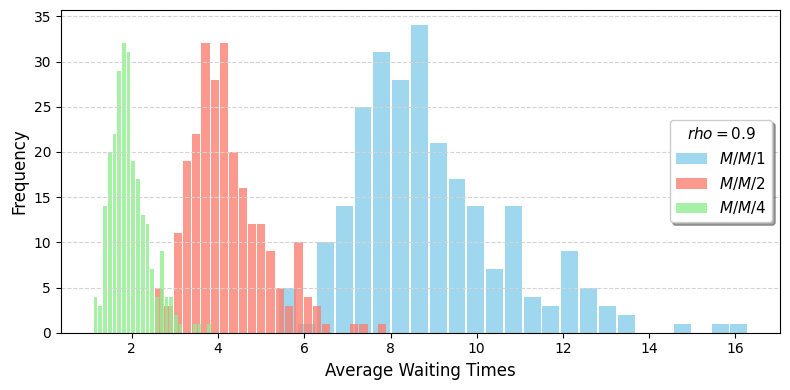

In [11]:
# Plot histogram of average wait times:
plt.figure(figsize=(8, 4))

plt.hist(d1['# avg_waiting_times'], bins=25, alpha=0.8, color='skyblue', label='$M/M/1$', rwidth=0.9)
plt.hist(d2['# avg_waiting_times'], bins=25, alpha=0.8, color='salmon', label='$M/M/2$', rwidth=0.9)
plt.hist(d4['# avg_waiting_times'], bins=25, alpha=0.8, color='lightgreen', label='$M/M/4$', rwidth=0.8)

plt.xlabel('Average Waiting Times', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
l = plt.legend(loc='center right', fontsize=11, shadow=True)
l.set_title(title='$rho = 0.9$', prop={'size': 11})
plt.grid(axis='y', linestyle='--', alpha=1, color='lightgray')
plt.tight_layout()

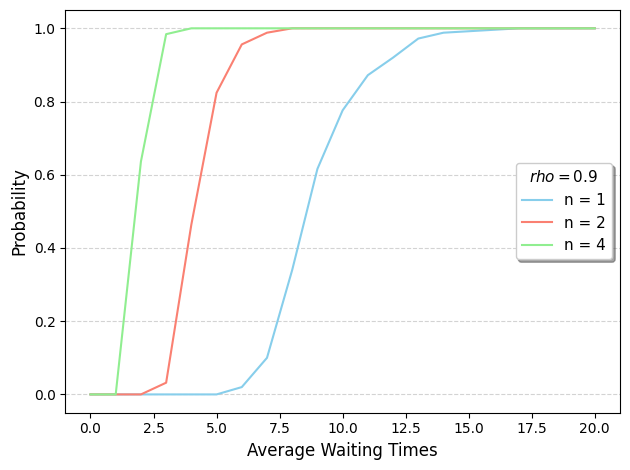

In [12]:
# Plot cummulative distribution:
results = [d1['# avg_waiting_times'],d2['# avg_waiting_times'],d4['# avg_waiting_times']]
n = [1,2,4]
colors = ['skyblue','salmon','lightgreen']

data_ar = []
for i in range(3):
    d = results[i]
    x = np.linspace(0,20,21)
    cumulative = [len(d[d< i])/len(d) for i in x]
    data_ar.append(cumulative)
    plt.plot(x,cumulative,label = "n = "+str(n[i]), color=colors[i])

plt.legend(loc='best')
plt.xlabel('Average Waiting Times', fontsize=12)
plt.ylabel('Probability', fontsize=12)
l = plt.legend(loc='center right', fontsize=11, shadow=True)
l.set_title(title='$rho = 0.9$', prop={'size': 11})
plt.grid(axis='y', linestyle='--', alpha=1, color='lightgray')
plt.tight_layout()

## Statistical Validation

---

Clearly, the individual distributions of the average waiting times are far apart, highlighting that they are not the same. However, to understand the statistical procedure, we now estimate the significance of the above results.

As we are comparing multiple samples, we can use a one-way analysis of variance. To this end, we can choose between an ANOVA test (which assumes normally distributed data) or a Kruskal-Willis test (the non-parametric alternative).

We first check the assumptions of the ANOVA:

Group 1 - Shapiro-Wilk Test: Statistics=0.943, p=0.000
Group 2 - Shapiro-Wilk Test: Statistics=0.942, p=0.000
Group 3 - Shapiro-Wilk Test: Statistics=0.943, p=0.000


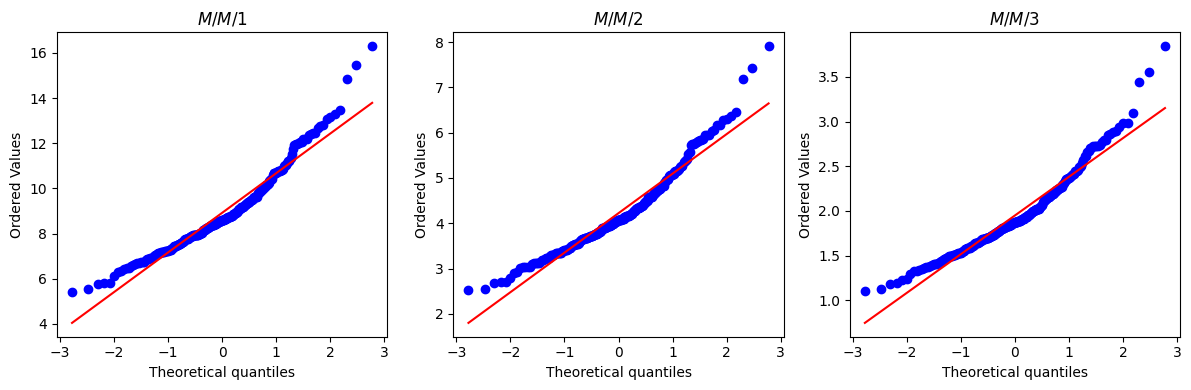

In [13]:
### Normality ###
for i, group in enumerate([d1['# avg_waiting_times'], d2['# avg_waiting_times'], d4['# avg_waiting_times']], 1):
    stat, p = stats.shapiro(group)
    print(f'Group {i} - Shapiro-Wilk Test: Statistics={stat:.3f}, p={p:.3f}') # p > 0.05, normal distribution

# Corresponding Q-Q plots:
plt.figure(figsize=(12, 4))

for i, group in enumerate([d1['# avg_waiting_times'], d2['# avg_waiting_times'], d4['# avg_waiting_times']], 1):
    plt.subplot(1, 3, i)
    stats.probplot(group, dist="norm", plot=plt)
    plt.title(f'$M/M/{i}$')

plt.tight_layout()
plt.show() # normal distribution if points lie on the line

The assumption of normality is violated. Thus, we use the Kruskal-Wallis test to examine whether the three obtained samples stem from the same distribution:

In [14]:

stat, p = stats.kruskal(d1['# avg_waiting_times'], d2['# avg_waiting_times'], d4['# avg_waiting_times'])
print(f'Kruskal-Wallis Test: H={stat:.3f}, p={p:.3f}')  # p < 0.05, significant differences found between the groups

Kruskal-Wallis Test: H=659.679, p=0.000


From this extreme result we conclude that there is a significant difference between our samples. To investigate what the underlying structure of these differences are, we use a post-hoc analysis:

In [15]:
stat, p = stats.mannwhitneyu(d1['# avg_waiting_times'], d2['# avg_waiting_times'])
print(f'Mann-Whitney U Test, \nM/M/1 > M/M/2: U={stat:.3f}, p={p:.3f}') # p < 0.05, significant differences found between the groups
stat, p = stats.mannwhitneyu(d1['# avg_waiting_times'], d4['# avg_waiting_times'])
print(f'M/M/1 > M/M/4: U={stat:.3f}, p={p:.3f}') # p < 0.05, significant differences found between the groups
stat, p = stats.mannwhitneyu(d2['# avg_waiting_times'], d4['# avg_waiting_times'])
print(f'M/M/2 > M/M/4: U={stat:.3f}, p={p:.3f}') # p < 0.05, significant differences found between the groups

Mann-Whitney U Test, 
M/M/1 > M/M/2: U=62242.000, p=0.000
M/M/1 > M/M/4: U=62500.000, p=0.000
M/M/2 > M/M/4: U=62184.000, p=0.000


*Note: An adjustment for multiple testing was ommitted because of the extreme results.* 

Thus, conclude that the following difference structure underlies the difference of the mean waiting times for the 3 systems, $$M/M/1 > M/M/2 > M/M/4$$